# 이미지 내 워터마크 제거 알고리즘

* kaggle에서 제공하는 피부질환 dataset 수집하면서 이미지 파일 내 워터마크가 포함된 이미지가 다수 있어 classification 모델 학습 시 성능이 저하되는 문제점이 있었음

* 이미지 전처리 과정에서, 이미지 내에 포함된 워터마크를 최대한 희미하게 처리하여 잘 보이지 않게 제거하는 방식으로 처리함.

* 아래 코딩으로 구현한 워터마크 제거 전처리 알고리즘 원리는 대략 아래와 같음.

  ① 워터마크 부분 모두 중앙에 위치하고 있어 해당부분 잘라서 평균연산(나온 배경 색이 글자 제외하고 거의 살색으로 균일함)

  ② 배경 대비 확연히 밝은 부분: 글자색 마스크

  ③ 배경 대비 확연히 어두운 부분: 그림자

  ④ 글자색 삭제 :
     - a(1-k)+bk = c, a=워터마크가 없던 색(구하고자함), b=워터마크색(흰색으로 255 대입), 
     - c=워터마크가 포함된 색, k=글자의 불투명도 (0.1 정도로 추정하여 내외로 변경해가며 대입)
현재색 a를 구하기 위해서 이항, a = (c - bk)/(1 - k) np.where 를 통해서 ② 에서 구한 마스크를 적용하여 일부분만 적용하고 나머진 그대로 적용

  ⑤ 그림자 삭제: ④와 동일 방법, ③의 마스크 적용하고 b = 0, k = 0.01 × (해당 픽셀 색상 - ①에서 나온 배경색), 0.01 도 미세조정함, 그림자는 투명도가 중요

# 워터마크 제거 예시

* 위 알고리즘을 통하여 투명한 회색 글자로 된 "Dermnet" 워터마크를 거의 보이지 않게 제거할 수 있었다.
* 이후 워터마크 제거된 이미지 데이터셋으로 모델 학습 결과 성능 향상 효과를 보았음.

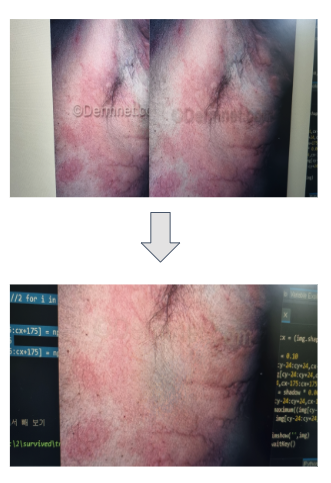

In [ ]:
raise Exception('블록쳐서 F9 눌러서 실행바랍니다.')

import cv2
import numpy as np
import pandas as pd
import os
import itertools

img = cv2.imread(r"C:\2\survived\train\Urticaria Hives\hives-Urticaria-Acute-31.jpg")

# 워터마크를 구하기 위해서 평균값 추출

files = os.listdir(r"C:\2\survived\train\Seborrheic Keratoses and other Benign Tumors"+"\\")

N = len(files)
wms = np.empty((N, 48,350,3))

for i, fn in itertools.islice(enumerate(files),N):
    img = cv2.imread(r"C:\2\survived\train\Seborrheic Keratoses and other Benign Tumors"+"\\"+fn)
    cy, cx = (img.shape[i]//2 for i in range(2))
    wm = img[cy-24:cy+24,cx-175:cx+175]
    wms[i] = wm


mini = np.minimum(wms.min(axis=0).round() * 4,255).astype('uint8')
maxi = np.maximum(wms.max(axis=0).round() * 4,255).astype('uint8')

cv2.imshow('',mini)
cv2.waitKey()
cv2.imwrite('minvalue.png',mini)

cv2.imshow('',maxi)
cv2.waitKey()
cv2.imwrite('maxvalue.png',maxi)


# 그림자관련


# 평균값 추출함
# [0]행을 기준으로 해서 뺄셈하여 양수 반영
# 그림자도 뺄셈을 해야 함


# 화이트마스크
meani = wms.mean(axis=0)
meani = meani.mean(axis=2)[...,np.newaxis]

wm = meani[:,:,:] > meani[0,:,:] + 3
wmask = np.where(wm, 255, 0).astype('uint8')
cv2.imwrite('wmask.png',wmask)


# 블랙마스크
meani = wms.mean(axis=0)
meani = meani.mean(axis=2)[...,np.newaxis]

bm = meani[:,:,:] < meani[0,:,:] - 2
bmask = np.where(bm, 255, 0).astype('uint8')
cv2.imwrite('bmask.png',bmask)


shadow = meani[0,:,:] - meani[:,:,:]

# 마스크 영역에서는 특정색으로 대체


img = cv2.imread(r"C:\2\survived\train\Urticaria Hives\dermagraphism-34.jpg")

cy, cx = (img.shape[i]//2 for i in range(2))

beta = 0.10
img[cy-24:cy+24,cx-175:cx+175] = np.where(wm, np.minimum((img[cy-24:cy+24,cx-175:cx+175]-255*beta)/(1-beta),255), img[cy-24:cy+24,cx-175:cx+175]).astype('uint8')
beta = shadow * 0.0085
img[cy-24:cy+24,cx-175:cx+175] = np.where(bm, np.minimum(np.maximum((img[cy-24:cy+24,cx-175:cx+175]-0*beta)/(1-beta),0),255), img[cy-24:cy+24,cx-175:cx+175])

cv2.imshow('',img)
cv2.waitKey()



# 하나의 디렉토리 각각 루프해서 dewater 디렉토리에 추가
with open(r"C:\2\dewater\error_reporting.txt", "at") as f:
    for dn in os.listdir(r"C:\2\archive\test"):
        print(dn)
        os.makedirs(r"C:\2\dewater\test"+"\\"+dn, exist_ok=True)
        for fn in os.listdir(r"C:\2\archive\test"+"\\"+dn+"\\"):
            try:
                print(fn)
                img = cv2.imread(r"C:\2\archive\test"+"\\"+dn+"\\"+fn)
                cy, cx = (img.shape[i]//2 for i in range(2))
                beta = 0.10
                img[cy-24:cy+24,cx-175:cx+175] = np.where(wm, np.minimum((img[cy-24:cy+24,cx-175:cx+175]-255*beta)/(1-beta),255), img[cy-24:cy+24,cx-175:cx+175]).astype('uint8')
                beta = shadow * 0.0085
                img[cy-24:cy+24,cx-175:cx+175] = np.where(bm, np.minimum(np.maximum((img[cy-24:cy+24,cx-175:cx+175]-0*beta)/(1-beta),0),255), img[cy-24:cy+24,cx-175:cx+175])
                cv2.imwrite(r"C:\2\dewater\test"+"\\"+dn+"\\"+fn,img)
            except Exception as e:
                f.write(dn)
                f.write('\n')
                f.write(fn)
                f.write('\n')
                f.write(str(e))
                f.write('\n\n')
                print(dn, fn, e)
            
        print(dn, 'Done!')